# Plots of Trade-offs

In this notebook we compare different time discretization methods. First, we collect
a trajectory data from the environment at a fine discretization level (this is also
the discretization level we run the policy at -- right now, anyway). Then we compare:

1. Using uniform discretization at different granularities, e.g. updating with every
    1st, 10th, 100th, ...? interactions.
2. Using the adaptive method with different tolarances.

In order to average out randomness, we'll repeat each setting 3 times for now.

In [1]:
import gymnasium as gym
from adaptive_time.features import Fourier_Features
import numpy as np
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import random
from joblib import Parallel, delayed

import adaptive_time.utils
from adaptive_time import environments
from adaptive_time import mc2
from adaptive_time import samplers

import enum

seed = 13

In [2]:
gym.register(
    id="CartPole-OURS-v0",
    entry_point="adaptive_time.environments.cartpole:CartPoleEnv",
    vector_entry_point="adaptive_time.environments.cartpole:CartPoleVectorEnv",
    max_episode_steps=500,
    reward_threshold=475.0,
)

def reset_randomness(seed, env):
    random.seed(seed)
    np.random.seed(seed)
    # env.seed(seed)
    env.action_space.seed(seed)

In [3]:
# Sample usage of the environment.
print(
    "We run the same environment and simple policy twice,\n"
    "with different time discretizations. The policy we use\n"
    "will always go left, so the time discretization does not\n"
    "make a difference to the behaviour, and the total return\n"
    "will be the same.")
print()

policy = lambda obs: 0

env = gym.make('CartPole-OURS-v0')
tau = 0.02
env.stepTime(tau)

reset_randomness(seed, env)
traj, early_term = environments.generate_trajectory(env, seed, policy)
total_return_1 = sum(ts[2] for ts in traj)
print("Total undiscounted return: ", total_return_1)

env = gym.make('CartPole-OURS-v0')
tau = 0.002
env.stepTime(tau)

reset_randomness(seed, env)
traj, early_term = environments.generate_trajectory(env, seed, policy)
total_return_2 = sum(ts[2] for ts in traj)
print("Total undiscounted return: ", total_return_2)

#np.testing.assert_almost_equal(total_return_1, total_return_2, decimal=0)

print()
print(
    "We can expect some difference because we may get an extra\n"
    "timesteps in the more fine-grained discretization, but the\n"
    "difference should be smallish.")

We run the same environment and simple policy twice,
with different time discretizations. The policy we use
will always go left, so the time discretization does not
make a difference to the behaviour, and the total return
will be the same.

Total undiscounted return:  10.589912009424973
Total undiscounted return:  100.17508472458734

We can expect some difference because we may get an extra
timesteps in the more fine-grained discretization, but the
difference should be smallish.


/Users/szepi1991/Code/adaptive_time/.venv/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.stepTime to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.stepTime` for environment variables or `env.get_wrapper_attr('stepTime')` that will search the reminding wrappers.
  logger.warn(


**NOTE** you must adjust the discount factor if changing time-scales!

In [4]:
phi = Fourier_Features()
phi.init_fourier_features(4,4)
x_thres = 4.8
theta_thres = 0.418
phi.init_state_normalizers(
    np.array([x_thres,2.0,theta_thres,1]),
    np.array([-x_thres,-2.0,-theta_thres,-1]))
phi.num_parameters

625

In [79]:
class BudgetType(enum.Enum):
    INTERACTIONS = 1
    UPDATES = 2


def run_experiment(
        seed, env, sampler, epsilon, budget, budget_type: BudgetType,
        termination_prob, gamma, tqdm=None, print_trajectory=False):
    """Keeps interacting until the budget is (approximately) used up, returns stats.
    
    Note that the budgets are in terms of processed interactions (or updates). We
    will do one last episode, even if the budget is used up, so that we can evaluate
    the final weights.
    """
    if tqdm is None:
        tqdm_use = lambda x: x

    # We record:
    total_return = [0]  # The total return at the end of each episode.
    total_pivots = [0]
    total_interactions = [0]
    num_episode = [0]

    # Each of the following will record the values for both actions.
    # Each element of these will be a (2,)-np.array, so we can just stack them.
    returns_per_episode_q = []
    predicted_returns_q = []

    reset_randomness(seed, env)

    observation, _ = env.reset(seed=seed)
    d = len(phi.get_fourier_feature(observation))
    assert d == phi.num_parameters
    features = np.identity(2 * d)   # An estimate of A = xx^T
    targets = np.zeros(2 * d)  # An estimate of b = xG
    weights = np.zeros(2 * d)   # The weights that approximate A^{-1} b

    x_0 = phi.get_fourier_feature([0,0,0,0])  # the initial state
    x_sa0 = mc2.phi_sa(x_0, 0)
    x_sa1 = mc2.phi_sa(x_0, 1)

    def remaining_steps():
        if budget_type == BudgetType.INTERACTIONS:
            return budget - total_interactions[-1]
        elif budget_type == BudgetType.UPDATES:
            return budget - total_pivots[-1]
        else:
            raise ValueError("Unknown budget type")

    def policy(state, weights):
        if random.random() < epsilon:
            return env.action_space.sample()
        # Otherwise calculate the best action.
        x = phi.get_fourier_feature(state)
        qs = np.zeros(2)
        for action in [0, 1]:
            x_sa = mc2.phi_sa(x, action)
            qs[action] = np.inner(x_sa.flatten(), weights)
        # adaptive_time.utils.softmax(qs, 1)
        return adaptive_time.utils.argmax(qs)

    while remaining_steps() > 0:

        trajectory, early_term = environments.generate_trajectory(
                env, policy=lambda s: policy(state=s, weights=weights),
                termination_prob=termination_prob)
        
        # Process and record the return.
        return_this_episode = sum(ts[2] for ts in trajectory)
        if total_return:
            total_return.append(total_return[-1] + return_this_episode)
        else:
            total_return.append(return_this_episode)

        if print_trajectory:
            print("trajectory-len: ", len(trajectory), "; trajectory:")
            for idx, (o, a, r, o_) in enumerate(trajectory):
                # * ignore reward, as it is always the same here.
                # * o_ is the same as the next o.
                print(f"* {idx:4d}: o: {o}\n\t --> action: {a}")

        assert early_term is False, "We should not terminate early in this experiment."

        # Do updates, record stats from the processed trajectory.
        weights, targets, features, cur_avr_returns, num_pivots = mc2.ols_monte_carlo(
            trajectory, sampler, tqdm_use, phi, weights, targets, features, x_0, gamma)
        
        # Update the stats.
        total_pivots.append(total_pivots[-1] + num_pivots)
        total_interactions.append(total_interactions[-1] + len(trajectory))
        num_episode.append(num_episode[-1] + 1)
        
        # Store the empirical and predicted returns. For any episode, we may
        # or may not have empirical returns for both actions. When we don't have an
        # estimate, `nan` is returned.
        returns_per_episode_q.append(cur_avr_returns)
        predicted_returns_q.append(np.array(
            [np.inner(x_sa0.flatten(), weights),
                np.inner(x_sa1.flatten(), weights)]))
    
    # The following variant produces plots where we can see
    # the effect of the last update.
    # # Do one more evaluation run.
    # trajectory, early_term = environments.generate_trajectory(
    #     env, policy=lambda s: policy(state=s, weights=weights),
    #     termination_prob=termination_prob)
    # return_this_episode = sum(ts[2] for ts in trajectory)
    # print(sampler, "final return: ", return_this_episode)
    # total_return.append(total_return[-1] + return_this_episode)

    return {
        "total_return": total_return,
        "total_pivots": total_pivots,
        "total_interactions": total_interactions,
        "num_episode": num_episode,
        "returns_per_episode_q": returns_per_episode_q,
        "predicted_returns_q": predicted_returns_q,
    }
    
    # The following variant produces plots where we
    # ensure that the last x-points are within the budget.
    # Do one more evaluation run.

    # return {
    #     "total_return": total_return,
    #     "total_pivots": total_pivots[:-1],
    #     "total_interactions": total_interactions[:-1],
    #     "num_episode": num_episode[:-1],
    #     "returns_per_episode_q": returns_per_episode_q,
    #     "predicted_returns_q": predicted_returns_q,
    # }
        


In [166]:
termination_prob=1.0/10000.0   # 1.0/500000.0
epsilon = 0.05
# budget = 10_000
# budget_type = BudgetType.INTERACTIONS
budget = 5_000
budget_type = BudgetType.UPDATES

num_runs = 2

tau = 0.002
# tau = 0.02
env.stepTime(tau)

# sampler = samplers.AdaptiveQuadratureSampler2(tolerance=0.1)
# sampler = samplers.AdaptiveQuadratureSampler2(tolerance=0.0)

samplers_tried = dict(
    q0_10=samplers.AdaptiveQuadratureSampler2(tolerance=10),
    q0_5=samplers.AdaptiveQuadratureSampler2(tolerance=5),
    q0_1=samplers.AdaptiveQuadratureSampler2(tolerance=1),
    u5=samplers.UniformSampler2(5),
    u10=samplers.UniformSampler2(10),
    u20=samplers.UniformSampler2(20),
)

results = {}
for name, sampler in tqdm(samplers_tried.items()):
    print(name, sampler)
    #results[name] = []
    results[name] = Parallel(n_jobs = num_runs)(
        delayed(run_experiment)(
            seed+run, env, sampler, epsilon, budget, budget_type,
            termination_prob, gamma=0.99999, tqdm=None, print_trajectory=False)
            for run in range(num_runs)
        )

'''
for name, sampler in samplers_tried.items():
    results[name] = []
    for run in range(num_runs):
        print()
        print(f"=============      Running experiment with sampler {name}, run={run}     =============")
        results[name].append(
            run_experiment(seed+run, env, sampler, epsilon, num_episodes, gamma=0.999, tqdm=None))
'''
print()
print("DONE!")

/Users/szepi1991/Code/adaptive_time/.venv/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.stepTime to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.stepTime` for environment variables or `env.get_wrapper_attr('stepTime')` that will search the reminding wrappers.
  logger.warn(


  0%|          | 0/6 [00:00<?, ?it/s]

q0_10 <adaptive_time.samplers.AdaptiveQuadratureSampler2 object at 0x13f0d38d0>
q0_5 <adaptive_time.samplers.AdaptiveQuadratureSampler2 object at 0x13fe91490>
q0_1 <adaptive_time.samplers.AdaptiveQuadratureSampler2 object at 0x13fc06550>
u5 <adaptive_time.samplers.UniformSampler2 object at 0x13f69da50>
u10 <adaptive_time.samplers.UniformSampler2 object at 0x2bb9f4390>
u20 <adaptive_time.samplers.UniformSampler2 object at 0x13fbe4050>

DONE!


In [173]:
# results["q0_5"][0]

In [174]:
def plot_perf(tuples_of_x_y_labels_kwargs, title, show):

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    for x, y, label, kwargs in tuples_of_x_y_labels_kwargs:
        plt.plot(x, y, label=label, **kwargs)

    plt.ylabel('Cumulative\nEpisode\nReturn', rotation=0, labelpad=40)
    plt.legend()

    if title is not None:
      plt.title(title)

    if show:
      plt.show()
    return ax


In [175]:


# # if len(results) > 8:
# #    raise ValueError("Too many results to plot")
# # colors = plt.cm.get_cmap('Set2')(np.linspace(0,1,len(results)))
# colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# tuples_of_x_y_labels_kwargs = []
# for i, (name, stats) in enumerate(results.items()):
#     for run in stats:
#         tuples_of_x_y_labels_kwargs.append((
#             run["total_interactions"],
#             run["total_return"],
#             name,
#             {"color": colors[i]}
#         ))

# ax = plot_perf(tuples_of_x_y_labels_kwargs,
#                "Total Return vs Interactions", False)
# # ax.set_yscale('log')
# ax.set_xlabel('Number of Interactions')
# # ax.set_ylim(24, 30)
# plt.show()


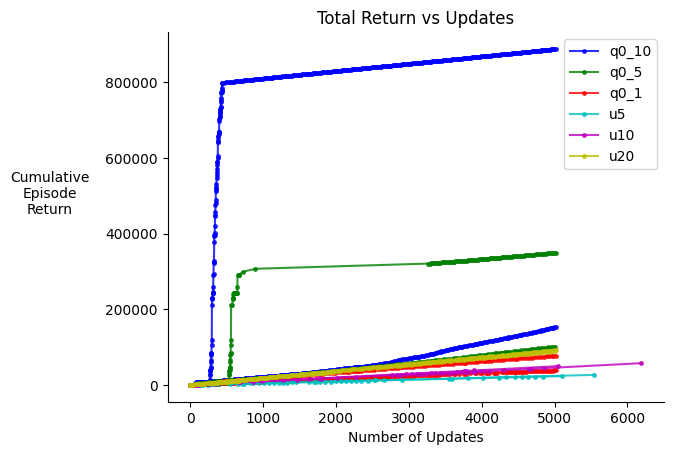

In [176]:

# ax = plt.gca()
# ax.cla()

# if len(results) > 8:
#    raise ValueError("Too many results to plot")
# colors = plt.cm.get_cmap('Set2')(np.linspace(0,1,len(results)))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

tuples_of_x_y_labels_kwargs = []
for i, (name, stats) in enumerate(results.items()):
    for r_idx, run in enumerate(stats):
        tuples_of_x_y_labels_kwargs.append((
            run["total_pivots"],
            run["total_return"],
            name if r_idx==0 else None,
            # {"color": colors[i], "marker": ".", "linestyle": "None", "markersize": 5, "alpha": 0.8}
            {"color": colors[i], "marker": ".", "linestyle": "-", "markersize": 5, "alpha": 0.8}
        ))

ax = plot_perf(tuples_of_x_y_labels_kwargs,
               "Total Return vs Updates", False)
# ax.set_yscale('log')
ax.set_xlabel('Number of Updates')
# if budget_type == BudgetType.UPDATES:
#     ax.set_xlim(-100, budget)
#     # Find the y-limits of the plot.
#     # for stats in .values():
#     for runs in results.values():
#         max_total_return = -1
#         for run in runs:
#             cur_max = max(run["total_return"][:-1])
#             if cur_max > max_total_return:
#                 max_total_return = cur_max

#     #     max_total_return = max(max(runs["total_return"][:-1]) for runs in results.values())
#     # max_total_return = max(max(runs["total_return"][:-1]) for runs in results.values())
#     # max_total_return = max(max(run["total_return"]) for run in results.values())
#     ax.set_ylim(-max_total_return/50, max_total_return)

# ax.set_ylim(24, 30)   
plt.show()


In [177]:
for x, y, label, kwargs in tuples_of_x_y_labels_kwargs:
    if label == "u20":
        print(x)
        print(y)
    

[0, 30, 70, 90, 97, 121, 142, 163, 184, 255, 267, 279, 291, 302, 313, 324, 335, 346, 357, 368, 379, 390, 401, 413, 439, 475, 510, 521, 532, 543, 555, 567, 585, 597, 609, 645, 646, 658, 665, 677, 712, 748, 1402, 1460, 1518, 1560, 1672, 1711, 1737, 1763, 1791, 1821, 1873, 1905, 1926, 1951, 1973, 2012, 2032, 2058, 2085, 2113, 2140, 2167, 2195, 2223, 2252, 2281, 2310, 2338, 2357, 2386, 2415, 2444, 2453, 2482, 2510, 2553, 2581, 2610, 2638, 2681, 2723, 2767, 2810, 2838, 2867, 2895, 2924, 2952, 2980, 3009, 3037, 3065, 3126, 3170, 3214, 3244, 3288, 3332, 3351, 3394, 3422, 3451, 3494, 3537, 3579, 3649, 3678, 3707, 3736, 3765, 3794, 3823, 3851, 3880, 3909, 3937, 3966, 3995, 4024, 4052, 4074, 4103, 4132, 4161, 4227, 4275, 4293, 4342, 4364, 4392, 4420, 4448, 4476, 4504, 4532, 4560, 4588, 4616, 4644, 4673, 4702, 4731, 4759, 4788, 4817, 4846, 4874, 4902, 4931, 4959, 4987, 5015]
[0, 560.6616017124973, 1290.3454935037505, 1648.6103823720161, 1759.2804150261786, 2186.769517084929, 2514.4059902860104, 2

In [178]:
len(results['q0_10'][0])

6

In [179]:
max_updates = max(
    max(run["total_pivots"][-1] for run in runs)
    for runs in results.values())
print(max_updates)

6186


In [180]:
all_updates = np.arange(0, max_updates+1)   # x-axis for the interpolated results

interpolated_results = {}  # Each element will be a numpy array
for name, stats_for_runs in results.items():
    interpolated_results[name] = np.zeros((len(stats_for_runs), len(all_updates)))
    for run_idx, run in enumerate(stats_for_runs):
        interpolated_results[name][run_idx] = np.interp(
            all_updates, run["total_pivots"], run["total_return"])

print(interpolated_results.keys())
print(interpolated_results['q0_10'].shape)

dict_keys(['q0_10', 'q0_5', 'q0_1', 'u5', 'u10', 'u20'])
(2, 6187)


In [181]:
mean_results = {}
for name, returns in interpolated_results.items():
    mean_results[name] = returns.mean(axis=0)


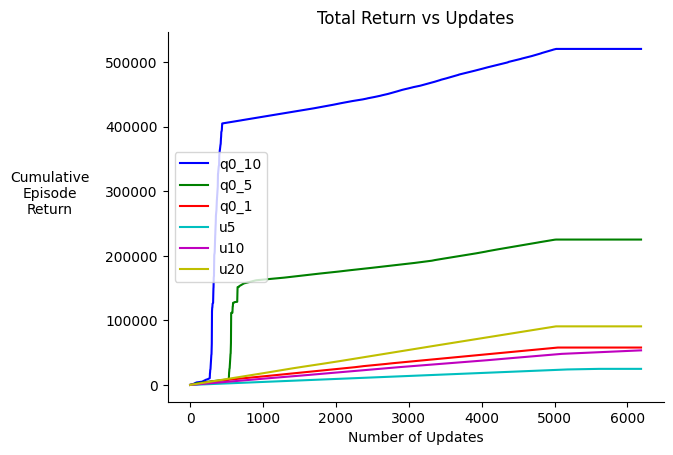

In [182]:

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

tuples_of_x_y_labels_kwargs = []
for i, (name, returns) in enumerate(mean_results.items()):
    tuples_of_x_y_labels_kwargs.append((
        all_updates, returns, name,
        # {"color": colors[i], "marker": ".", "linestyle": "None", "markersize": 5, "alpha": 0.8}
        {"color": colors[i], "marker": "", "linestyle": "-"}
    ))


# for i, (name, stats) in enumerate(results.items()):
#     for r_idx, run in enumerate(stats):
#         tuples_of_x_y_labels_kwargs.append((
#             run["total_pivots"],
#             run["total_return"],
#             None,
#             # name if r_idx==0 else None,
#             # {"color": colors[i], "marker": ".", "linestyle": "None", "markersize": 5, "alpha": 0.8}
#             # {"color": colors[i], "marker": ".", "linestyle": "-", "markersize": 5, "alpha": 0.8}
#             {"color": colors[i], "marker": "", "linestyle": "-", "alpha": 0.2}
#         ))


ax = plot_perf(tuples_of_x_y_labels_kwargs,
               "Total Return vs Updates", False)
# ax.set_yscale('log')
ax.set_xlabel('Number of Updates')
plt.show()


In [183]:

# print()
# print("Results, a list of num_episodes, and a list of num_pivots for the different seeds:")
# for name, sub_results in results.items():
#     num_episodes, num_pivots, num_interactions = zip(*sub_results)
#     print(f"* {name}")
#     if -1 in num_episodes:
#         num_eps_stats = f"?? +- ??"
#     else:
#         mean_num_episodes = np.mean(num_episodes)
#         std_err_episodes = np.std(num_episodes) / np.sqrt(len(num_episodes))
#         num_eps_stats = f"{np.mean(num_episodes):.2f} +- {std_err_episodes:.2f}"

#     std_err_pivots = np.std(num_pivots) / np.sqrt(len(num_pivots))
#     std_err_num_interactions = np.std(num_interactions) / np.sqrt(len(num_interactions))
#     print(f"    * num_episodes: {num_eps_stats}                full list: {num_episodes}")
#     print(f"    * num_pivots:   {np.mean(num_pivots):.2f} +- {std_err_pivots:.2f}           full list: {num_pivots}")
#     print(f"    * num_interactions:   {np.mean(num_interactions):.2f} +- {std_err_num_interactions:.2f}"
#           f"           full list: {num_interactions}")



In [184]:
print(epsilon)

0.05
